## MPII 데이터셋 사용

## 데이터 전처리 하기

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
# 라이브러리 불러오기

import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, '/models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('완료')

완료


In [2]:
# json 파싱하기
# 데이터 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 pose estimation(관절)을 위한 label로 삼을 수 있다
# json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 보자
# json.dumps()를 활용해서 좀 더 명확하게 하면 좋다

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)
    
# joints가 우리가 label로 사용할 keypoint 이다
# 이미지 형상과 사람의 포즈에 따라 모든 label이 이미지에 나타나지 않기 때문에,
# joints_vis를 이용해서 실제로 사용할 수 있는 keypoint인지 나타낸다
# MPII는 1/0으로만 나우어지기 때문에 조금 더 쉽게 사용할 수 있다

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
# scale과 center는 사람 몸의 크기 비율과 중심점이다
# scale은 200을 곱해야 온전한 크기가 된다
# 추후에 전처리 과정에서 200을 곱해서 사용할 예정이다

# json annotation을 파싱하는 함수 만들기
# = 이미지에 있는 체크 포인트를 배열로 바꾸는 과정을 나타내는 함수를 만들어라

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('완료')

완료


In [4]:
# paese_one_annotation()함수 테스트하기

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


## TFRecord 파일 만들기

In [5]:
# 앞서 추출한 annotation을 TFRecord로 변환하는 함수 만들기
# = TFRcord는 대규모 데이터셋을 효율적으로 저장하고 읽기 위한 바이너리 파일 형식을 말한다
# TFRecord는 tf.train.Example들의 합으로 이루어지므로 하나의 annotation을 하나의 tf.train.Example로 만들어주는 함수부터 작성한다

def generate_tfexample(anno):

    # TensorFlow 텐서를 바이너리 값으로 변환
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    # 주어진 annotation에서 이미지 파일 이름과 경로 읽음
    filename = anno['filename']
    filepath = anno['filepath']
    
    # 이미지 파일을 읽어 바이너리 데이터로 저장
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    
    # 이미지 형식이 JPEG이 아니거나 RGB 모드가 아닌 경우, 변환 수행
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    # 이미지의 크기 및 채널 정보 추출
    width, height = image.size
    depth = 3

    # Annotation에서 중심 좌표(center) 정보 추출
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    # 관절 데이터에서 x 좌표 추출 (값이 음수인 경우 그대로 사용)
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 관절 데이터에서 y 좌표 추출 (값이 음수인 경우 그대로 사용)
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 관절 가시성 데이터 변환 (가시성이 0이면 0, 그렇지 않으면 2로 변환)
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    # TFRecord에서 사용될 Feature 정의
    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('완료')

완료


In [6]:
# 여러 annotation에 대해 작업할 수 있도록 함수 만들기
# 하나의 TFRecord를 만들지 않고 여러 TFRecord 만들어야 한다
# 우선 얼마나 많은 TFRecord를 만들지 결정할 함수를 만든다

# 이 함수는 전체 데이터를 몇 개의 그룹으로 나눌지 결정한다
# 전체 데이터 |를 n그룹으로 나눈다 결과적으로 n개의 TFRecord파일 만들겠다는 이야기이다

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('완료')

# 위 과정을 전문적으로 n개로 shard 했다고 한다
# 하나의 큰 데이터를 여러 개의 파일로 쪼개고 여러 컴퓨터에 나누어 담는 것이라고 여기면 된다
# 이렇게 하면 데이터 저장에도 용이하고 병렬 처리 하는데 이점이 있다

# 너무 작은 파일로 많이 나누는 것도 너무 큰 파일로 적게 나누는 것도 좋지 않다
# 너무 작은 파일로 많이 나누면 학습 중간에 너무 작은 입출력이 요구된다
# 너무 큰 파일로 적게 나누면 입출력마다 걸리는 시간이 길어딘다

# 적절한 파일 크기와 개수는 케바케라고 할 수 있다

완료


In [7]:
# chunkify 함수 테스트하기

test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

# 0이 1000개 들어 있는 리스트가 64개로 쪼개졌다

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수 만들기

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('완료')

# chunk안에는 여러 annotation들이 있고, annotation들은 tf.train.Example로 변환된 후에 문자열로 직렬화되어 TFRecord에 닮긴다
# Ray는 병렬 처리를 위한 라이브러리이다
# 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있다

완료


In [9]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수 만들기
# ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다 (주의)

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('완료')

완료


## Ray

In [10]:
# 앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어준다
# train 데이터는 64개로 val 데이터는 8개의 파일로 만든다
# ray는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있다
# 시간이 오래 걸린다

# TFRecord를 위한 샤드 개수 정의
num_train_shards = 64
num_val_shards = 8

# Ray 라이브러리 초기화(병렬 처리를 위해 사용)
ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

# 학습 데이터 annotation 파일 열기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

# 검증 데이터 annotation 파일 열기
with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train') # # 학습 데이터를 TFRecord 파일로 변환
build_tf_records(val_annotations, num_val_shards, 'val') # # 검증 데이터를 TFRecord 파일로 변환

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-01-06 06:26:44,065	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.92gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

## data label로 만들기

In [11]:
# TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요하다
# tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단하다
# 주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 순서가 같아야 한다는 점이다
# 데이터 형식도 동일하게 맞춰야 한다

def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('완료')

# 이렇게 얻은 image와 label을 이용해 적절한 학습 형태로 변환한다

완료


In [12]:
# 우리가 알고 있는 것은 joints의 위치, center의 좌표, body height 값이다
# 균일하게 학습하기 위해 body width를 적절히 정하는 것도 중요하다
# 우리가 임의로 조정한 crop box가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점이다

# 이미지에서 관심영역(ROI)을 잘라내고 keypoint 좌표를 잘라낸 영역에 맞게 조정하는 함수
def crop_roi(image, features, margin=0.2):
    
    # 이미지의 크기 정보 가져오기
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    # keypoint 좌표를 밀집 텐서로 변환하고 정수형으로 캐스팅
    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    
    # 중심점 좌표 및 스케일 값 가져오기
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # 유효한 keypoint만 남기기 (값이 0보다 큰 경우)
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # keypoint의 최소값 및 최대값 계산
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 관심영역(ROI)의 좌표 계산 (정사각형 형태로 조정)
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # ROI가 이미지 크기를 벗어나지 않도록 조정
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    # 이미지에서 ROI를 잘라냄
    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    
    # 잘라낸 이미지의 크기 가져오기
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    # Keypoint 좌표를 잘라낸 이미지 기준으로 정규화
    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('완료')

완료


In [13]:
# (x, y) 좌표로 되어있는 keypoint를 heatmap으로 변경한다
# 2D 가우시안 히트맵 생성 함수

def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    # 가우시안 영역의 경계 계산
    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    # 가우시안 영역이 이미지 밖에 있거나 가시성이 0인 경우 빈 히트맵 반환
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    # 가우시안 분포를 계산하기 위한 격자 생성
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    # 가우시안 중심 좌표
    center_x = size // 2
    center_y = size // 2

    # 가우시안 패치 계산
    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    # 가우시안 패치와 히트맵의 유효한 영역 계산
    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    # 유효한 영역을 순회하며 가우시안 값을 히트맵에 추가
    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    # 계산된 가우시안 패치를 히트맵에 업데이트
    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap


# 주어진 keypoint 데이터를 기반으로 2D 가우시안 히트맵 배열 생성

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    # 각 keypoint에 대해 가우시안 히트맵 생성
    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    # 히트맵 배열을 스택하고 형태를 (H, W, D)로 변환
    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('완료')

# keypoint가 주어졌을 때 ex.손목(300, 400)
# keypoint를 가우시안 히트맵으로 변환 ex. ...   0   0   1   2   1   0   0   ...
# 각각의 이미지의 히트맵은 개별적으로 생성되고 나중에 3D 하트맵 텐서로 합쳐짐

완료


In [14]:
# 지금까지 만든 함수들을 객체 형태로 조합한다
# 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많다
# 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 한다

# 이미지와 키포인트 데이터를 전처리하는 클래스
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    # 전처리 시작
    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

    # 관심영역(POI)를 추출하고 키포인트 좌표를 POI 기준으로 정규화 
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        # Keypoint 좌표 및 중심점 정보 가져오기
        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        # 유효한 Keypoint만 남기기
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        # Keypoint의 최소 및 최대값 계산
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        # ROI의 경계 계산
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        # 이미지 크기를 초과하지 않도록 경계 조정
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        # 이미지에서 ROI 추출
        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        # Keypoint 좌표를 ROI 기준으로 정규화
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    # 가우시안 히트맵 생성
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        # 가우시안 경계 계산
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        # 유효하지 않은 경우 빈 히트맵 반환
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        # 가우시안 분포 계산
        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')
        center_x = size // 2
        center_y = size // 2
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # 유효한 영역 계산
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # 히트맵에 가우시안 패치 추가
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap

    # keypoint 데이터를 기반으로 히트맵 생성
    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    # TFRecord에서 데이터를 파싱
    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('완료')

완료


## 모델을 학습해보자
- hourglass 모델

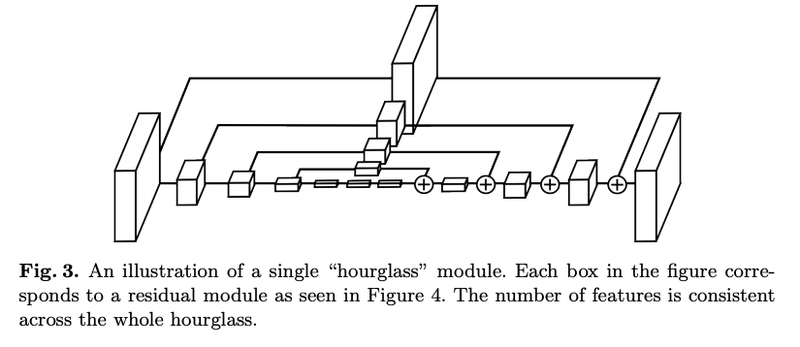

In [15]:
# 직육면체 박스는 residual block 이다

# Resnet의 bottleneck block 구현
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    
    # downsample이 True인 경우, 입력 크기와 채널 수를 맞추기 위해 1x1 컨볼루션 수행
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    # 첫 번째 Batch Normalization + ReLU 활성화
    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    # 첫 번째 1x1 컨볼루션 (채널 수를 filters//2로 줄임)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)
    
    # 두 번째 Batch Normalization + ReLU 활성화
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    # 두 번째 3x3 컨볼루션 (spatial 크기를 strides에 따라 조정)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    # 세 번째 Batch Normalization + ReLU 활성화
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    # 세 번째 1x1 컨볼루션 (채널 수를 filters로 복구)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    # Residual 연결
    x = Add()([identity, x])
    return x

print('완료')

완료


In [16]:
# hourglass 모델은 양파처럼 가장 바깥의 layer를 제거하면 똑같은 구조가 나타나는 것을 알 수 있다
# 재귀 함수를 이용해 간단하게 모델을 표현할 수 있다
# 바깥부터 5개의 층을 만들고 싶다면 order를 이용해 5,4,3,2,1이 될 때까지 hourglassModule을 반복하면 order가 1이 되면 bottlenechBlock으로 대체해 주면 아주 간결하게 만들 수 있다

def HourglassModule(inputs, order, filters, num_residual):
    
    # 업샘플링 경로 (상위 특징 추출)
    # 첫 번째 BottleneckBlock 적용
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # 다운샘플링 경로 (하위 특징 추출)
    # MaxPool2D를 사용해 해상도 축소
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    # 재귀적으로 HourglassModule 호출
    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual) # Order가 1보다 크면 재귀 호출하여 다음 단계로 이동
    else:
        for i in range(num_residual): # Order가 1이면 BottleneckBlock을 num_residual만큼 반복 적용
            low2 = BottleneckBlock(low2, filters, downsample=False)

    # 다운샘플링 경로에서 업샘플링
    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    # 업샘플링 수행
    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('완료')

# 여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워 저자들은 inermediate supervision을 적용했다
# 도식에서 보이는 모듈 사이의 네트워크의 파란 박스는 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer이다
# 이 히트맵과 ground truth의 차이를 inermediate loss로 계산한다
# 이로써 이 모델은 보다 정교한 결과를 도출한다

완료


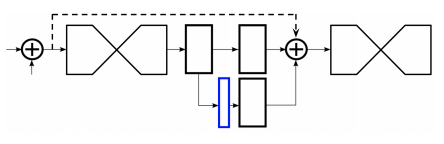

In [17]:
# stacked 되는 hourglass 층 사이사이에 linearlayer를 삽입하고 중간 loss를 계산한다
# 지금까지 만든 hourglass를 여러 층으로 쌓으면 stacjed hourglass가 된다

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('완료')

완료


In [18]:
# StackedHourglassNetwork를 사용하면 모델을 쉽게 만들 수 있다

def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    # 입력
    inputs = Input(shape=input_shape)

    # 첫 번째 Conv2D 레이어: 특징 추출
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    
    # BottleneckBlock으로 특징 추출 및 차원 조정
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    # Stacked Hourglass 모듈 반복
    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual) # Hourglass 모듈 호출
        for i in range(num_residual): # BottleneckBlock 반복 적용
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256) # LinearLayer로 최종 특징 추출

        # 히트맵 생성 (Conv2D로 keypoint 개수에 맞게 출력)
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # Intermediate 연결: 다음 Hourglass 스택을 위한 처리
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('완료')

완료


In [19]:
stackedhourglassnetwork_model = StackedHourglassNetwork()
stackedhourglassnetwork_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

In [20]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [21]:
def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet = tf.keras.applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet'
    )
    x = resnet(inputs)
    x = _make_deconv_layer(3)(x)
    out = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [22]:
simplebaseline_model = Simplebaseline()
simplebaseline_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


## 학습 엔진 만들기

In [23]:
class Trainer(object):
    def __init__(self,
                 model_name,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        # 학습할 텐서플로우 모델을 저장합니다
        if model_name == "simple-baseline":
            self.model = Simplebaseline()
        elif model_name == "stacked-hourglass":
            self.model = StackedHourglassNetwork()
        else:
            raise ValueError("지원되지 않는 모델 이름입니다.")
        self.model_name = model_name
        # 전체 학습 에포크 수를 저장합니다.
        self.epochs = epochs
        # 분산 학습에 사용할 tf.distribute.Strategy 객체를 저장합니다.
        self.strategy = strategy
        # 전체 배치 크기를 저장합니다.
        self.global_batch_size = global_batch_size
        # 손실 함수로 MeanSquaredError를 정의
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE # 각 샘플에 대한 개별 손실 값을 유지
        )
        # 옵티마이저를 정의하고 초기 학습률로 설정합니다.
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate
        )
#         self.model = model
        # 현재 학습률을 저장합니다. 학습 중 감소할 수 있습니다.
        self.current_learning_rate = initial_learning_rate
        # 직전 에포크의 검증 손실을 저장합니다.
        self.last_val_loss = math.inf
        # 현재까지 가장 낮은 검증 손실을 저장하여 성능 향상 여부를 모니터링합니다.
        self.lowest_val_loss = math.inf
        # 조기 종료를 위한 patience 카운터를 초기화합니다.
        self.patience_count = 0
        # 학습률을 감소시키기 전의 최대 patience 설정입니다.
        self.max_patience = 10
        # 가장 좋은 성능을 기록한 모델 경로를 저장합니다.
        self.best_model = None

    def lr_decay(self):
        '''학습률을 조정하는 메서드입니다.
        patience가 max_patience에 도달하면 학습률을 10배 감소시키고 
        patience를 초기화합니다.
        '''
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        '''에포크별로 학습률을 감소시키는 메서드입니다. 
        특정 에포크(25, 50, 75)에서 학습률을 10배 감소시킵니다.
        '''
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        '''
        모델 출력과 실제 레이블을 비교하여 가중치를 적용한 손실을 계산합니다. 
        배치 크기에 따라 손실을 나누어 정규화합니다.
        '''
        loss = tf.constant(0.0, dtype=tf.float32)  # float32 타입으로 초기화
        labels = tf.cast(labels, dtype=tf.float32)  # labels를 float32로 변환
        
        for output in outputs:
            output = tf.cast(output, dtype=tf.float32)  # output을 float32로 변환
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss
    
    def distance_from_prob(self, y_true, y_pred):
        """Get keypoint distance from heatmap probability.
        from https://github.com/samson6460/tf2_pose_estimation/blob/master/metrics/distance_metrics.py
        """
        if isinstance(y_pred, list):
            y_pred = y_pred[0]
        height, width = y_pred.get_shape()[1:3]

        index_map_x = tf.range(width, dtype=y_true.dtype)
        index_map_x = tf.reshape(index_map_x, (1, 1, -1, 1))
        index_map_y = tf.range(height, dtype=y_true.dtype)
        index_map_y = tf.reshape(index_map_y, (1, -1, 1, 1))

        y_true_map_x = y_true*index_map_x
        y_true_map_y = y_true*index_map_y
        y_pred_map_x = y_pred*index_map_x
        y_pred_map_y = y_pred*index_map_y

        y_true_x = tf.reduce_sum(y_true_map_x, axis=(1, 2))
        y_true_y = tf.reduce_sum(y_true_map_y, axis=(1, 2))
        y_pred_x = tf.reduce_sum(y_pred_map_x, axis=(1, 2))
        y_pred_y = tf.reduce_sum(y_pred_map_y, axis=(1, 2))

        dist = tf.math.sqrt(
            (y_true_x - y_pred_x)**2 + (y_true_y - y_pred_y)**2)

        dist = tf.reduce_mean(dist, axis=-1)

        return dist

    def train_step(self, inputs):
        '''
        학습 단계에서 사용되는 함수입니다. GradientTape로 모델 출력을 추적하고, 
        손실에 따라 그래디언트를 계산 후 옵티마이저로 가중치를 업데이트합니다.
        '''
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)
            metric_dist = self.distance_from_prob(labels, outputs)

        grads = tape.gradient(
            target=loss, 
            sources=self.model.trainable_variables
        )
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )

        return loss, metric_dist

    def val_step(self, inputs):
        '''
        검증 단계에서 사용됩니다. 검증용 데이터에 대해 모델을 평가하여 손실을 
        계산합니다.
        '''
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        metric_dist = self.distance_from_prob(labels, outputs)

        return loss, metric_dist

    def run(self, train_dist_dataset, val_dist_dataset):
        '''
        전체 학습 프로세스를 관리합니다. 에포크별로 학습 및 검증을 수행하고 
        모델 성능이 향상될 때마다 모델을 저장합니다.
        '''
        @tf.function
        def distributed_train_epoch(dataset):
            '''
            학습 데이터셋을 분산 학습하며 에포크 단위로 반복합니다. 배치 손실을
            계산하고 출력합니다.
            '''
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            total_metric_dist = tf.constant(0.0, dtype=tf.float32)
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_metric_dist = self.strategy.run(
                    self.train_step, 
                    args=(one_batch, )
                )
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_replica_loss, 
                    axis=None
                )
                batch_metric_dist = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_metric_dist, 
                    axis=None
                )
                
                total_loss += tf.cast(batch_loss, tf.float32)
                total_metric_dist += tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))
                num_train_batches += 1
                
                # 100번째 배치마다 출력
                if tf.equal(num_train_batches % 100, 0):
                    tf.print(
                        'Trained batch', num_train_batches, 
                        'batch loss', batch_loss, 
                        'epoch total loss', total_loss / num_train_batches,
                        'epoch reduce mean metric dist', tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))
                    )

            return total_loss, num_train_batches, total_metric_dist

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            total_metric_dist = tf.constant(0.0, dtype=tf.float32)           
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_metric_dist = self.strategy.run(
                    self.val_step, 
                    args=(one_batch, )
                )
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_replica_loss, 
                    axis=None
                )
                batch_metric_dist = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_metric_dist, 
                    axis=None
                )
                # 100번째 배치마다 출력
                if tf.equal(num_val_batches % 100, 0):
                    tf.print(
                        'Validated batch', num_val_batches, 
                        'batch loss', batch_loss, 
                        'batch metric distance', batch_metric_dist
                    )
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += tf.cast(batch_loss, tf.float32)
                else:
                    num_val_batches -= 1
                
                total_metric_dist += tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))

            return total_loss, num_val_batches, total_metric_dist

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print(
                '#####    Start epoch {} with learning rate {}    #####'.format(
                    epoch, self.current_learning_rate
                )
            )
            train_total_loss, num_train_batches, train_total_metric_dist = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            train_metric_dist = train_total_metric_dist / num_train_batches
            print(
                '##    Epoch {} train loss {} train metric dist {}'.format(
                    epoch, train_loss, train_metric_dist
                )
            )

            val_total_loss, num_val_batches, val_total_metric_dist = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            val_metric_dist = val_total_metric_dist / num_val_batches
            print(
                '##    Epoch {} val loss {} val metrci dist {}'.format(
                    epoch, val_loss, val_metric_dist
                )
            )

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_nm = MODEL_PATH + f'/{self.model_name}-epoch-{epoch}-loss-{loss}.h5'
        self.model.save_weights(model_nm)
        self.best_model = model_nm
        print("##    Model {} saved.".format(model_nm))
        
print('완료')

완료


In [24]:
# 데이터셋을 만드는 함수 만들기
# TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러온다

IMAGE_SHAPE = (256, 256, 3) # 입력 이미지 크기 (높이, 너비, 채널 수)
HEATMAP_SIZE = (64, 64) # 출력 히트맵 크기 (높이, 너비)

# TFRecord 데이터를 기반으로 TensorFlow Dataset 객체를 생성
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('완료')

완료


In [25]:
# 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다

# 모델 학습을 위한 함수
def train(model_name, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    
    # 다중 gpu 분산 전략 설정
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 학습 및 검증 데이터셋 생성
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    # 모델 저장 디렉토리 생성
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    # 분산 전략 범위 설정
    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        trainer = Trainer(
            model_name,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('완료')

완료


In [26]:
# 학습하기
# 1에폭 당 1시간 가까이 걸린다

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [27]:
model_name = "stacked-hourglass"
best_stacked_hourglass_file = train(model_name, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 100 batch loss 1.53422868 epoch total loss 1.82966137 epoch reduce mean metric dist 120151.5
Trained batch 200 batch loss 1.59156716 epoch total loss 1.73437428 epoch reduce mean metric dist 121109.539
Trained batch 300 batch loss 1.75514412 epoch total loss 1.68995678 epoch reduce mean metric dist 93482.1328
Trained batch 400 batch loss 1.61931598 epoch total loss 1.66813231 epoch reduce mean metric dist 92134.875
Trained batch 500 batch loss 1.56882679 epoch total loss 1.64709044 epoch reduce mean metric dist 81274.8047
Trained batch 600 batch loss 1.55905616 epoch total loss 1.62549698 epoch reduce mean metric dist 78451.4531
Trained batch 700 batch loss 1.43478906 epoch total loss 1.60873556 epoch reduce mean metric dist 73386.5703
Trained batch 800 batch loss 1.57452381 epoch total loss 1.5997113 epoch reduce mean metric dist 69172.0469
Trained batch 900 batch loss 1.56336904 epoch total loss 1.5903461 epoch reduce mean metric dist 7467

In [28]:
model_name = "simple-baseline"
best_simple_baseline_file = train(model_name, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
#####    Start epoch 1 with learning rate 0.0007    #####
Start distributed traininng...
Trained batch 100 batch loss 6.61606741 epoch total loss 6.71967506 epoch reduce mean metric dist 87340.375
Trained batch 200 batch loss 5.42118549 epoch total loss 6.59747791 epoch reduce mean metric dist 88507.1719
Trained batch 300 batch loss 6.78125191 epoch total loss 6.57523155 epoch reduce mean metric dist 81701
Trained batch 400 batch loss 6.70812 epoch total loss 6.52258 epoch reduce mean metric dist 93744.9531
Trained batch 500 batch loss 6.58743477 epoch total loss 6.51183701 epoch reduce mean metric dist 86836.3281
Trained batch 600 batch loss 5.88855362 epoch total loss 6.47660828 epoch reduce mean metric dist 80478.2109
Trained batch 700 batch loss 6.12879705 epoch total loss 6.45923567 epoch reduce mean metric dist 83191.2
Trained batch 800 batch loss 6.39535379 epo

In [29]:
# 학습된 모델 불러오기

# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'stacked-hourglass-epoch-5-loss-1.1700599193572998.h5')

stackedhourglass_model = StackedHourglassNetwork()
# stackedhourglass_model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
stackedhourglass_model.load_weights(best_stacked_hourglass_file)

In [30]:
# 학습된 모델 불러오기

# WEIGHTS_PATH_simp = os.path.join(PROJECT_PATH, 'models', 'simple-baseline-epoch-5-loss-6.29601526260376.h5')

simplebaseline_model = Simplebaseline()
# simplebaseline_model.load_weights(WEIGHTS_PATH_simp)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
simplebaseline_model.load_weights(best_simple_baseline_file)

In [31]:
# keypoint를 사용해야 하기 때문에 필요한 변수 지정하기
# 변수에 저장되는 것은 해당 부위를 나타내는 인덱스이다

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('완료')

완료


In [32]:
# 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap이다
# 그래서 이 heatmap으로부터 좌표를 추출해야한다
# heatmap에서 최대값을 찾는 함수 만들기

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('완료')

완료


In [33]:
# 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해준다

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('완료')

완료


In [34]:
# 이제 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 준다

def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('완료')

완료


In [35]:
# 두 가지 함수를 각각 작성해준다

def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('완료')

완료


## StackedHourglass 모델


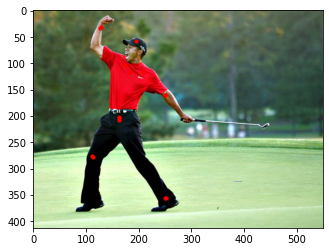

## SimpleBaseline 모델


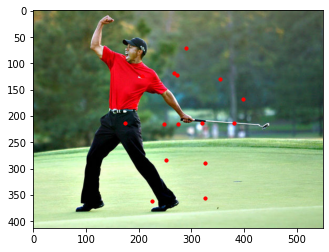

## StackedHourglass 모델


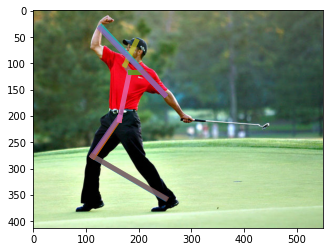

## SimpleBaseline 모델


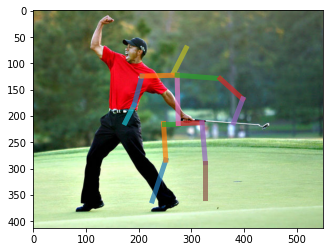

In [36]:
# 데스트 이미지를 이용해 모델의 성능 확인하기

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

stackedhourglass_image, stackedhourglass_keypoints = predict(stackedhourglass_model, test_image)
simplebaseline_image, simplebaseline_keypoints = predict(simplebaseline_model, test_image)

print("## StackedHourglass 모델")
draw_keypoints_on_image(stackedhourglass_image, stackedhourglass_keypoints)
print("## SimpleBaseline 모델")
draw_keypoints_on_image(simplebaseline_image, simplebaseline_keypoints)

print("## StackedHourglass 모델")
draw_skeleton_on_image(stackedhourglass_image, stackedhourglass_keypoints)
print("## SimpleBaseline 모델")
draw_skeleton_on_image(simplebaseline_image, simplebaseline_keypoints)

---
---
---